# 이미지 분류

**저자:** [fchollet](https://twitter.com/fchollet)<br>
**묘사:** 캐글 고양이와 강아지 데이터셋으로 이미지 분류 연습

## 과졔

데스크탑에 저장돼있는 캐글 고양이 강아지 데이터셋 JPEG 이미지를 어떻게 분류하는가 하는 모델이다.

여기서는 `image_dataset_from_directory` 유틸리티 함수를 사용해 데이터셋을 생성하고, 
tf.keras.preprocessing을 이용해 이미지 정규화와 증강을 시도한다.


## 라이브러리 불러오기


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


## 데이터 로딩: the Cats vs Dogs dataset

### 원시 데이터 다운로드

- colab을 사용하는 경우 다음 라인을 이용해 데이터셋을 다운로드 한다. (768M zip 파일)

In [2]:
#!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip


In [3]:
# !unzip -q kagglecatsanddogs_3367a.zip
# !ls


Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each
 subfolder contains image files for each category.


In [4]:
#!ls PetImages


### 불량 이미지를 필터링한다. 

실제 이미지 데이터를 가지고 작업할 때 항상 불량 이미지 문제가 발생한다.
헤더에 'JFIF'가 나타나지 않는 잘 못 인코딩된 이미지를 제거하자.

In [6]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # 불량 이미지는 넘어간다. 
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 0 images


## `데이터셋`  생성


In [7]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


## 데이터 시각화 

훈련셋의 이미지 9개를 살펴보자. label 1이 강아지고 0이 고양이임을 알 수 있다.


In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

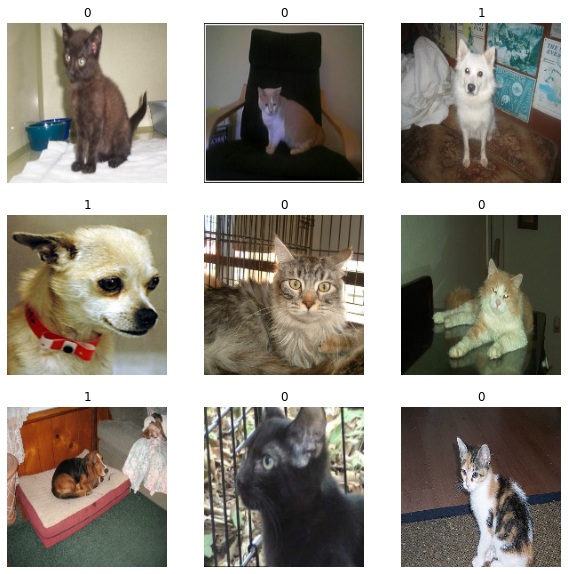

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## 이미지 데이터 증강을 사용하자. 

이미지 데이터셋이 크기 않을 때 훈련 이미지에 랜덤 수직 반전 도는 작은 랜덤 회전 같은 
랜덤하지만 여전히 현실적인 변환을 가해 샘플의 다양성을 확보하는 것은 좋은 관행이다.
이는 훈련데이터의 상이한 측면을 포착하게 하면서 과적합을 완화한다.

In [10]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)


데이터셋의 첫번째 이미지에 'data_augmentatin'을 반복적으로 적용함으로서 샘플이 어떻게 변하느지 증강된 샘플을 시각화해보자. 

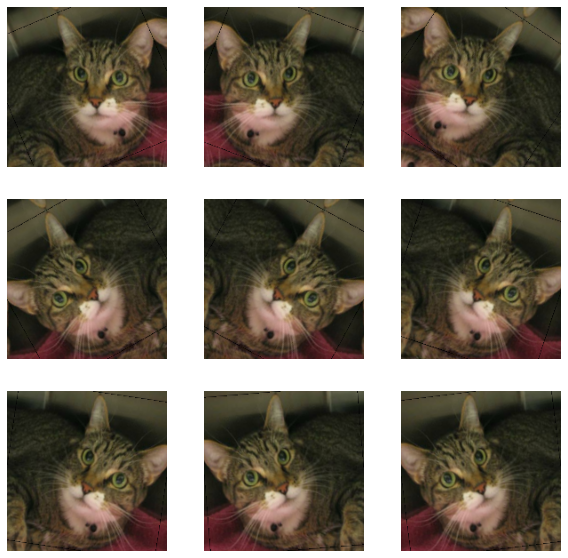

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


## 데이터 표준화

우리의 데이터셋에 의한 'float32' 배치에 의해 산출됐으므로 우리의 이미지는 이미 표준크기 (180x180)이다..
그러나 RGB 채널의 값은 [0, 255]이고 이는 신경망에 최적의 단위는 아니다.
- 일반적으로 입력이미지를 작게하는데, 여기서는 신경망의 처음부분에서  'Rescaling' 층을 사용해 값이 [0, 1] 내에 있도록 표준화한다.


## 데이터 전처리를 위한 2가지 옵션 

`data_augmentation` 전처리를 사용하는 2가지 방법이 있다. 

**옵션 1: 모델의 부분으로 만든다.**, 다음을 참조하라:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
...  # Rest of the model
```

이 옵션으로 데이터 증강은 *장비 위*에서 다른 모델 실행과 동기적으로 일어난다. 즉 GPU 의 가속에 혜택을 받을 것이다.
데이터 증강은 테스트 기간에는 비활성화된다. 따라서 입력 샘플이 'fit()' 동안 증강되며, 'evaluate()'나 'predict()'에서는 
증강되지 않는다.

- 만약 GPU를 사용하면 옵션 1이 좋은 옵션이다.


** 옵션 2: 데이터셋에 적용한다. **, 따라서 증강된 이미지의 배치를 산출하는 데이터셋을 얻는다.

```python
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))
```

이 옵션으로 데이터증강은 **CPU 상**에서 비동기적으로 일어나며, 모델에 들어가지 전에 버퍼링되다.

만약 CPU로 학습을 한다면 옵션2가 좋은 옵션이다. 왜냐하면, 이는 데이터증강을 비동기적으로 그리고 비방해적으로 만들기 때문이다.

여기서는 첫번째 옵션을 선택한다. 여러분은 두번째 옵션을 시도해보기를 바란다.

## 성능 향상을 위한 데이터셋 구성

버퍼 프리페칭(buffered prefetching)을 사용해 데이터가 디스크로부터 I/0가 방해받지 않고 산출되도록 한다.


In [12]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


## 모델 구축

작은 버전의 Xception network를 구축한다. 베스트 모델을 구축하기 위한 하이퍼라미터 조정을 위해서는 다음을 참고하라.
[Keras Tuner](https://github.com/keras-team/keras-tuner).

Note that:

- 우리는 `data_augmentation` 전처리가 있는 모델로 시작해 'Rescaling' 층을 실행한다..
- 마지막 분류층 이전에 드롭아웃층을 추가하낟.


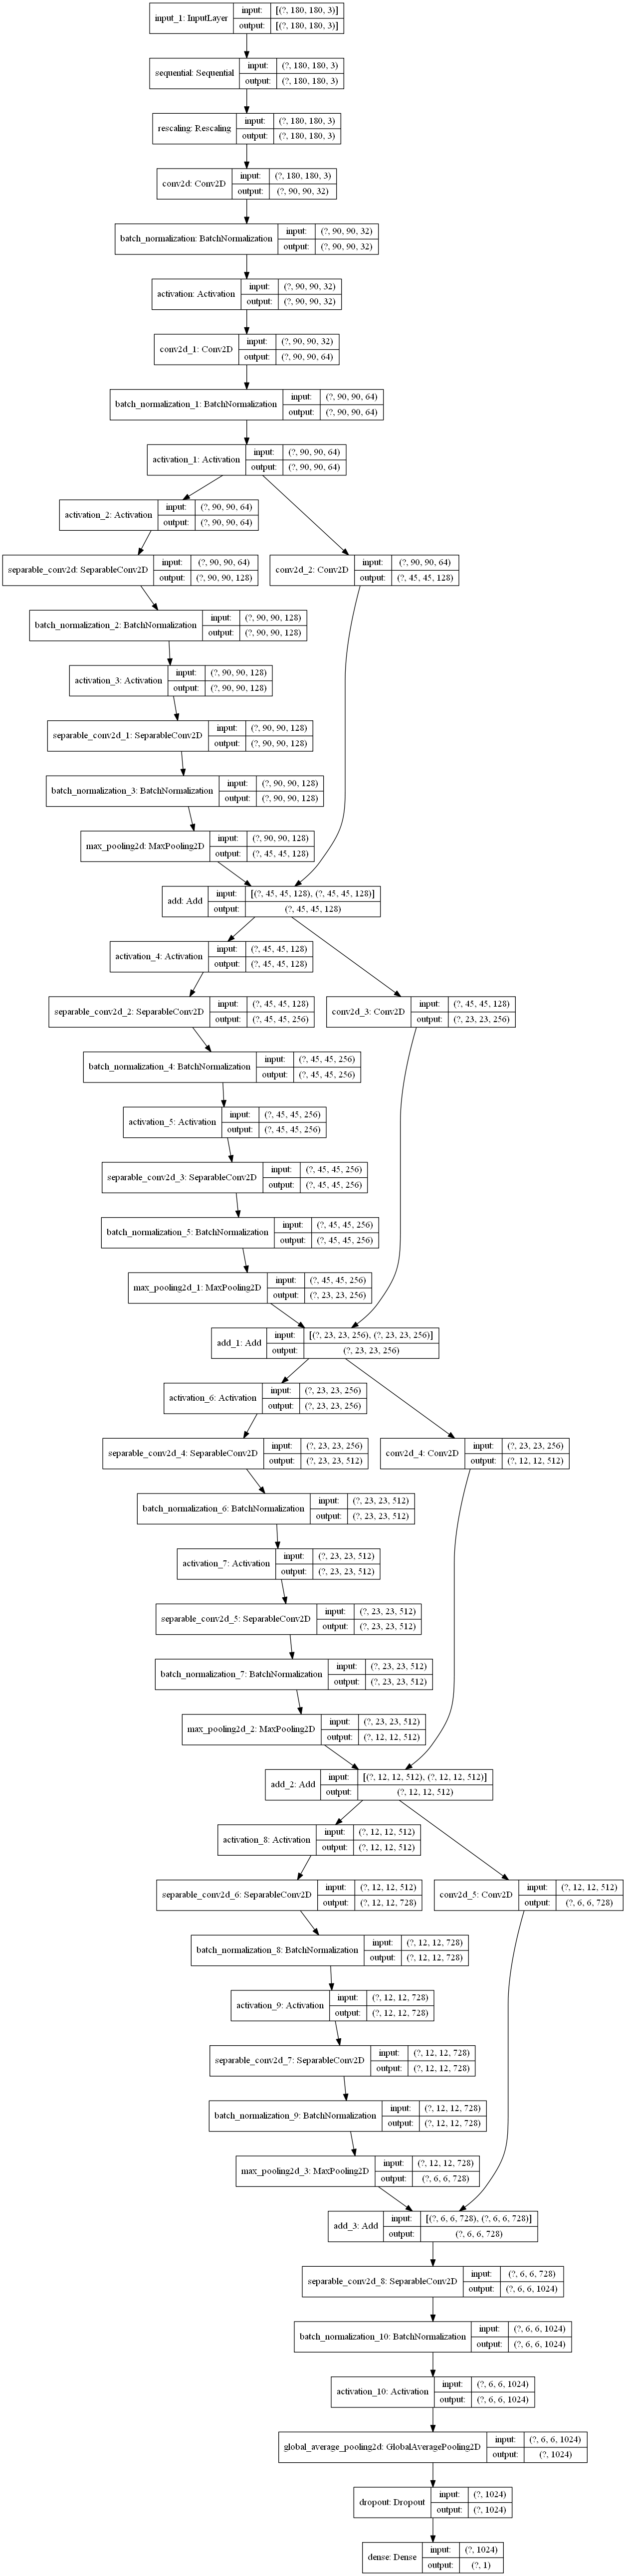

In [14]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    #  이미지 증강 블록
    x = data_augmentation(inputs)

    # 초기 블록
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # 잔차를 위해 보류

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # 이전 잔차를 conv2d를 통해 투영
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # 잔차를 다시 더함
        previous_block_activation = x  # 다음 잔차를 위해 보류

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


## Train the model


In [15]:
epochs = 3 #50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


Epoch 1/3
586/586 [==============================] - 4592s 8s/step - loss: 0.6125 - accuracy: 0.6659 - val_loss: 0.5223 - val_accuracy: 0.7434
Epoch 2/3
586/586 [==============================] - 4655s 8s/step - loss: 0.4531 - accuracy: 0.7903 - val_loss: 0.3976 - val_accuracy: 0.8207
Epoch 3/3
586/586 [==============================] - 4941s 8s/step - loss: 0.3546 - accuracy: 0.8480 - val_loss: 1.6161 - val_accuracy: 0.5798


We get to ~96% validation accuracy after training for 50 epochs on the full dataset.


## 새로운 데이터로 추론 실행

추론에서 데이터 증강과 드롭아웃은 비활성화됨을 주목하라..


This image is 0.26 percent cat and 99.74 percent dog.


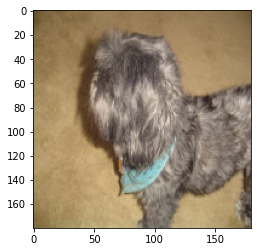

In [32]:
img = keras.preprocessing.image.load_img(
    "PetImages/dog/6671.jpg", target_size=image_size
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)
